# **Laboratorio 12: 🚀 Despliegue 🚀**

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Fabrizzio Pezzolla
- Nombre de alumno 2: Rodrigo Molina

### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/frpezzolla/lab_mds.git)

## Temas a tratar

- Entrenamiento y registro de modelos usando MLFlow.
- Despliegue de modelo usando FastAPI
- Containerización del proyecto usando Docker

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar una solución a un problema a partir de ML
- Desplegar su solución usando MLFlow, FastAPI y Docker

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# **Introducción**

Consumida en la tristeza el despido de Renacín, Smapina ha decaído en su desempeño, lo que se ha traducido en un irregular tratamiento del agua. Esto ha implicado una baja en la calidad del agua, llegando a haber algunos puntos de la comuna en la que el vital elemento no es apto para el consumo humano. Es por esto que la sanitaria pública de la municipalidad de Maipú se ha contactado con ustedes para que le entreguen una urgente solución a este problema (a la vez que dejan a Smapina, al igual que Renacín, sin trabajo 😔).

El problema que la empresa le ha solicitado resolver es el de elaborar un sistema que les permita saber si el agua es potable o no. Para esto, la sanitaria les ha **provisto** una base de datos con la lectura de múltiples sensores IOT colocados en diversas cañerías, conductos y estanques. Estos sensores señalan nueve tipos de mediciones químicas y más una etiqueta elaborada en laboratorio que indica si el agua es potable o no el agua.

La idea final es que puedan, en el caso que el agua no sea potable, dar un aviso inmediato para corregir el problema. Tenga en cuenta que parte del equipo docente vive en Maipú y su intoxicación podría implicar graves problemas para el cierre del curso.

Atributos:

1. pH value
2. Hardness
3. Solids (Total dissolved solids - TDS)
4. Chloramines
5. Sulfate
6. Conductivity
7. Organic_carbon
8. Trihalomethanes
9. Turbidity

Variable a predecir:

10. Potability (1 si es potable, 0 no potable)

Descripción de cada atributo se pueden encontrar en el siguiente link: [dataset](https://www.kaggle.com/adityakadiwal/water-potability)

# **1. Optimización de modelos con Optuna + MLFlow (2.0 puntos)**

El objetivo de esta sección es que ustedes puedan combinar Optuna con MLFlow para poder realizar la optimización de los hiperparámetros de sus modelos.

Como aún no hemos hablado nada sobre `MLFlow` cabe preguntarse: **¡¿Qué !"#@ es `MLflow`?!**

## **MLFlow**

`MLflow` es una plataforma de código abierto que simplifica la gestión y seguimiento de proyectos de aprendizaje automático. Con sus herramientas, los desarrolladores pueden organizar, rastrear y comparar experimentos, además de registrar modelos y controlar versiones.

Si bien esta plataforma cuenta con un gran número de herramientas y funcionalidades, en este laboratorio trabajaremos con dos:
1. **Runs**: Registro que constituye la información guardada tras la ejecución de un entrenamiento. Cada `run` tiene su propio run_id, el cual sirve como identificador para el entrenamiento en sí mismo. Dentro de cada `run` podremos acceder a información como los hiperparámetros utilizados, las métricas obtenidas, las librerías requeridas y hasta nos permite descargar el modelo entrenado.
2. **Experiments**: Se utilizan para agrupar y organizar diferentes ejecuciones de modelos (`runs`). En ese sentido, un experimento puede agrupar 1 o más `runs`. De esta manera, es posible también registrar métricas, parámetros y archivos (artefactos) asociados a cada experimento.

### **Todo bien pero entonces, ¿cómo se usa en la práctica `MLflow`?**

Es sencillo! Considerando un problema de machine learning genérico, podemos registrar la información relevante del entrenamiento ejecutando `mlflow.autolog()` antes entrenar nuestro modelo. Veamos este bonito ejemplo facilitado por los mismos creadores de `MLflow`:

```python
#!pip install mlflow
import mlflow # importar mlflow

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

db = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train models.
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)

mlflow.autolog() # registrar automáticamente información del entrenamiento
with mlflow.start_run(): # delimita inicio y fin del run
    # aquí comienza el run
    rf.fit(X_train, y_train) # train the model
    predictions = rf.predict(X_test) # Use the model to make predictions on the test dataset.
    # aquí termina el run
```

Si ustedes ejecutan el código anterior en sus máquinas locales (desde un jupyter notebook por ejemplo) se darán cuenta que en su directorio *root* se ha creado la carpeta `mlruns`. Esta carpeta lleva el tracking de todos los entrenamientos ejecutados desde el directorio root (importante: si se cambian de directorio y vuelven a ejecutar el código anterior, se creará otra carpeta y no tendrán acceso al entrenamiento anterior). Para visualizar estos entrenamientos, `MLflow` nos facilita hermosa interfaz visual a la que podemos acceder ejecutando:

```
mlflow ui
```

Les dejamos también algunos comandos útiles:

- `mlflow.create_experiment("nombre_experimento")`: Les permite crear un nuevo experimento para agrupar entrenamientos
- `mlflow.log_metric("nombre_métrica", métrica)`: Les permite registrar una métrica *custom* bajo el nombre de "nombre_métrica"


## **1.1 Combinando Optuna + MLflow (2.0 puntos)**

Ahora que tenemos conocimiento de ambas herramientas, intentemos ahora combinarlas para **más sabor**. El objetivo de este apartado es simple: automatizar la optimización de los parámetros de nuestros modelos usando `Optuna` y registrando de forma automática cada resultado en `MLFlow`.

Considerando el objetivo planteado, se le pide completar la función `optimize_model`, la cual debe:
- **Optimizar los hiperparámetros del modelo `XGBoost` usando `Optuna`.**
- **Registrar cada entrenamiento en un experimento nuevo**, asegurándose de que la métrica `f1-score` se registre como `"valid_f1"`. No se deben guardar todos los experimentos en *Default*; en su lugar, cada `experiment` y `run` deben tener nombres interpretables, reconocibles y diferentes a los nombres por defecto (por ejemplo, para un run: "XGBoost con lr 0.1").
- **Guardar los gráficos de Optuna** dentro de una carpeta de artefactos de Mlflow llamada `/plots`.
- **Devolver el mejor modelo** usando la función `get_best_model` y serializarlo en el disco con `pickle.dump`. Luego, guardar el modelo en la carpeta `/models`.
- **Guardar el código en `optimize.py`**. La ejecución de `python optimize.py` debería ejecutar la función `optimize_model`.
- **Guardar las versiones de las librerías utilizadas** en el desarrollo.
- **Respalde las configuraciones del modelo final y la importancia de las variables** en un gráfico dentro de la carpeta `/plots` creada anteriormente.

*Hint: Le puede ser útil revisar los parámetros que recibe `mlflow.start_run`*

```python
def get_best_model(experiment_id):
    runs = mlflow.search_runs(experiment_id)
    best_model_id = runs.sort_values("metrics.valid_f1")["run_id"].iloc[0]
    best_model = mlflow.sklearn.load_model("runs:/" + best_model_id + "/model")

    return best_model
```

In [1]:
import optuna

optuna.logging.set_verbosity(optuna.logging.DEBUG)

In [ ]:
def optimize_model():
  pass

# **2. FastAPI (2.0 puntos)**

Con el modelo ya entrenado, la idea de esta sección es generar una API REST a la cual se le pueda hacer *requests* para así interactuar con su modelo. En particular, se le pide:

- Guardar el código de esta sección en el archivo `main.py`. Note que ejecutar `python main.py` debería levantar el servidor en el puerto por defecto.
- Defina `GET` con ruta tipo *home* que describa brevemente su modelo, el problema que intenta resolver, su entrada y salida.
- Defina un `POST` a la ruta `/potabilidad/` donde utilice su mejor optimizado para predecir si una medición de agua es o no potable. Por ejemplo, una llamada de esta ruta con un *body*:

```json
{
   "ph":10.316400384553162,
   "Hardness":217.2668424334475,
   "Solids":10676.508475429378,
   "Chloramines":3.445514571005745,
   "Sulfate":397.7549459751925,
   "Conductivity":492.20647361771086,
   "Organic_carbon":12.812732207582542,
   "Trihalomethanes":72.28192021570328,
   "Turbidity":3.4073494284238364
}
```

Su servidor debería retornar una respuesta HTML con código 200 con:


```json
{
  "potabilidad": 0 # respuesta puede variar según el clasificador que entrenen
}
```

**`HINT:` Recuerde que puede utilizar [http://localhost:8000/docs](http://localhost:8000/docs) para hacer un `POST`.**

# **3. Docker (2 puntos)**

Tras el éxito de su aplicación web para generar la salida, Smapina le solicita que genere un contenedor para poder ejecutarla en cualquier computador de la empresa de agua potable.

## **3.1 Creación de Container (1 punto)**

Cree un Dockerfile que use una imagen base de Python, copie los archivos del proyecto e instale las dependencias desde un `requirements.txt`. Con esto, construya y ejecute el contenedor Docker para la API configurada anteriormente. Entregue el código fuente (incluyendo `main.py`, `requirements.txt`, y `Dockerfile`) y la imagen Docker de la aplicación. Para la dockerización, asegúrese de cumplir con los siguientes puntos:

1. **Generar un archivo `.dockerignore`** que ignore carpetas y archivos innecesarios dentro del contenedor.
2. **Configurar un volumen** que permita la persistencia de los datos en una ruta local del computador.
3. **Exponer el puerto** para acceder a la ruta de la API sin tener que entrar al contenedor directamente.
4. **Incluir imágenes en el notebook** que muestren la ejecución del contenedor y los resultados obtenidos.
5. **Revisar y comentar los recursos utilizados por el contenedor**. Analice si los contenedores son livianos en términos de recursos.

**3.1.** Con la ayuda de `docker init` se crea un archivo Dockerfile con el siguiente contenido:

```bash
# syntax=docker/dockerfile:1

ARG PYTHON_VERSION=3.10.15
FROM python:${PYTHON_VERSION}-slim as base

# Prevents Python from writing pyc files.
ENV PYTHONDONTWRITEBYTECODE=1

# Keeps Python from buffering stdout and stderr to avoid situations where
# the application crashes without emitting any logs due to buffering.
ENV PYTHONUNBUFFERED=1

WORKDIR /app

RUN --mount=type=cache,target=/root/.cache/pip \
    --mount=type=bind,source=requirements.txt,target=requirements.txt \
    python -m pip install -r requirements.txt

# Copy the source code into the container.
COPY . .

# Expose the port that the application listens on.
EXPOSE 8000

# Run the application.
CMD uvicorn 'main:app' --host=0.0.0.0 --port=8000
```

Se crea el archivo `compose.yaml` con:

```bash
services:
  server:
    build:
      context: .
    ports:
      - 8000:8000
    volumes:
      - potability:/home/node/app
volumes:
  potability:
```

Se crea también un .dockerignore con el siguiente contenido:

```bash
**/.DS_Store
**/__pycache__
**/.venv
**/.classpath
**/.dockerignore
**/.env
**/.git
**/.gitignore
**/.project
**/.settings
**/.toolstarget
**/.vs
**/.vscode
**/*.*proj.user
**/*.dbmdl
**/*.jfm
**/bin
**/charts
**/docker-compose*
**/compose.y*ml
**/Dockerfile*
**/node_modules
**/npm-debug.log
**/obj
**/secrets.dev.yaml
**/values.dev.yaml
**/optimize.py
**/*.md
**/*.json
**/plots/*
**/mlruns/*
**/*.csv
LICENSE
README.md
```

Se construye el contenedor desde la misma carpeta:
```bash
docker compose -p potability-api up --build
```

La aplicación se abre exitosamente desde [http://localhost:8000/](http://localhost:8000/):

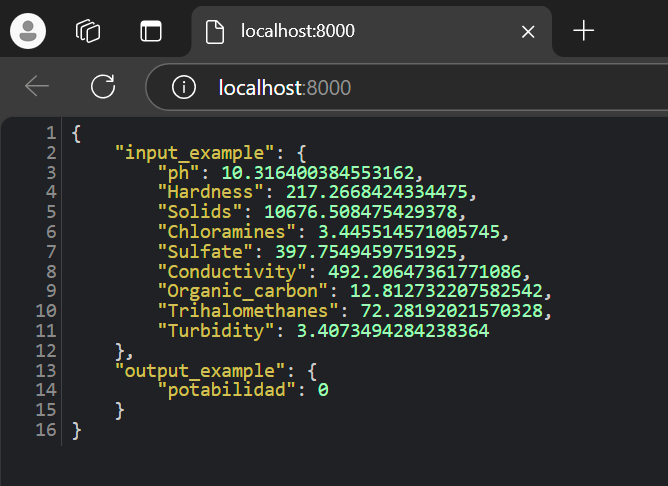
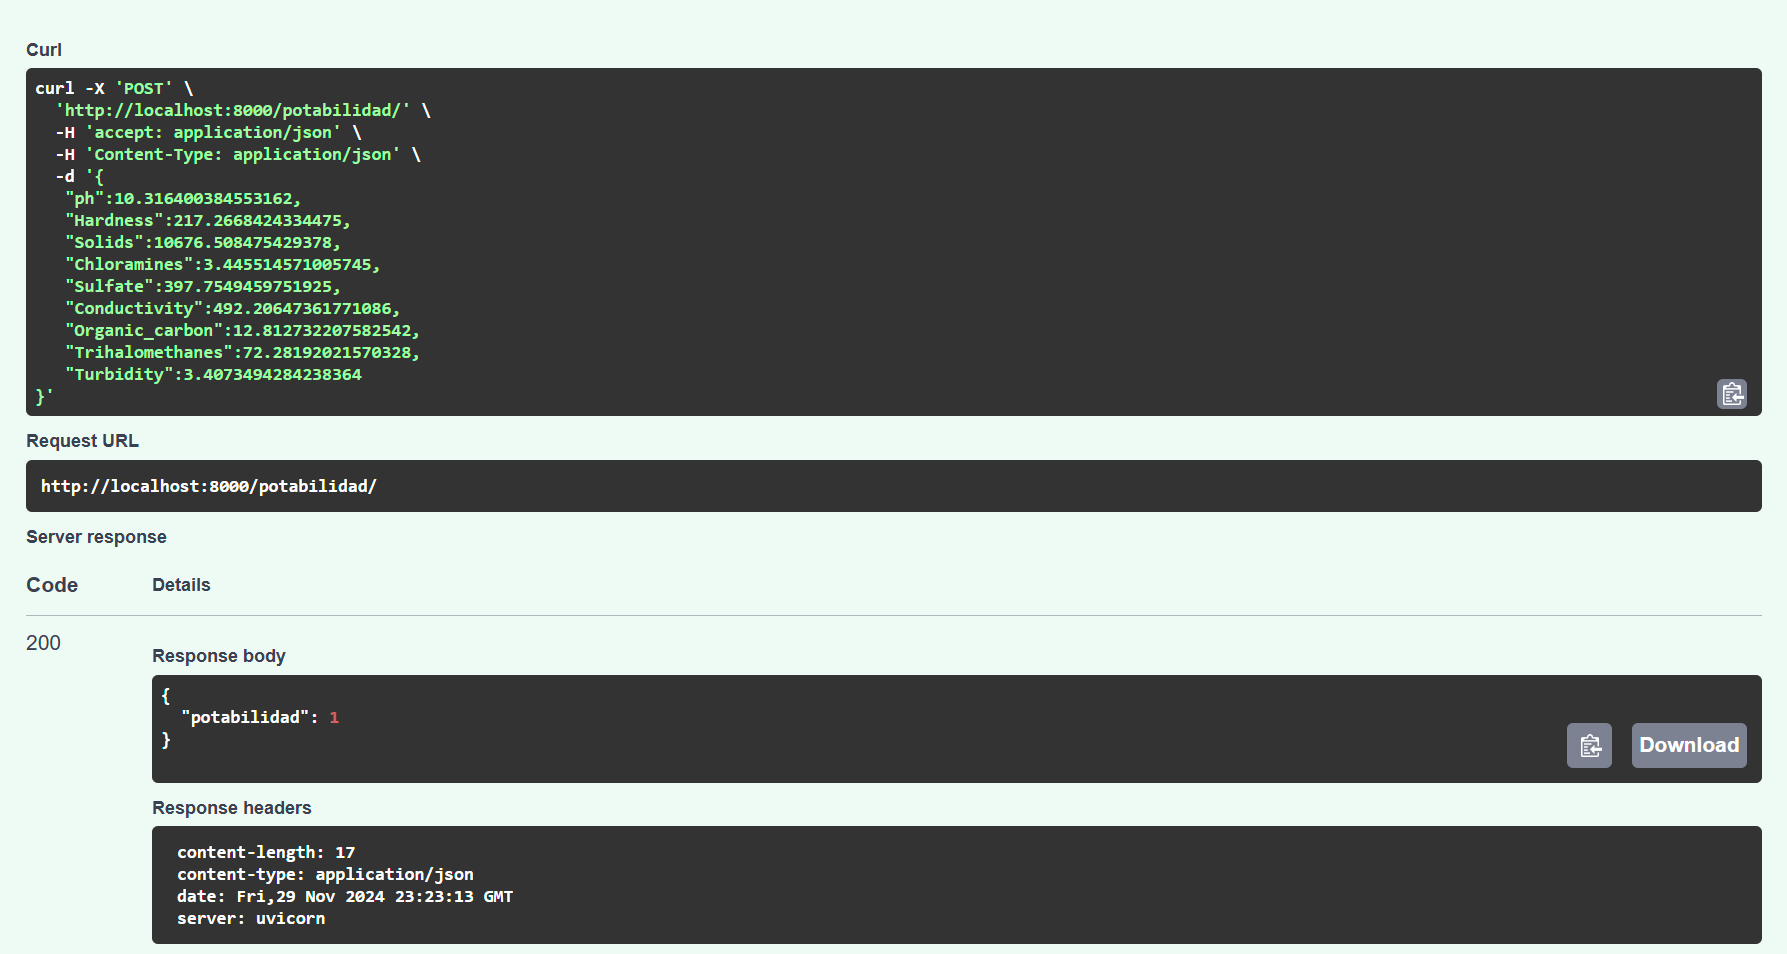

Finalmente, se guarda la imagen usando 
```bash
docker save potability-api-server > potability.tar
```

El uso de memoria del container no parece ser grande, siendo de apenas 98.81MB de los 15.16GB que Docker tiene asignado. El tamaño de la imagen es de 1.08GB, mucho menor a una instalación virgen de algún OS.

## **3.2 Preguntas de Smapina (1 punto)**
Tras haber experimentado con Docker, Smapina desea profundizar más en el tema y decide realizarle las siguientes consultas:

- ¿Cómo se diferencia Docker de una máquina virtual (VM)?
- ¿Cuál es la diferencia entre usar Docker y ejecutar la aplicación directamente en el sistema local?
- ¿Cómo asegura Docker la consistencia entre diferentes entornos de desarrollo y producción?
- ¿Cómo se gestionan los volúmenes en Docker para la persistencia de datos?
- ¿Qué son Dockerfile y docker-compose.yml, y cuál es su propósito?

**3.2.**

**3.2.1**

- Las máquinas virtuales utilizan un hypervisor para emular hardware completo, incluyendo el sistema operativo. Correr una máquina virtual implica correr todos los servicios del OS emulado. Las máquinas virtuales también toman tiempo en arrancar, porque inicializan el OS completo.

- Docker utiliza el sistema operativo del host y comparte los recursos, reduciendo los requerimentos del programa. Se construyen desde archivos de configuración, lo que es más sencillo y rápido. Solamente se encarga de lo absolutamente necesario para ejecutar la aplicación.

**3.2.2**

- Ejecutar una aplicación directamente en el sistema local puede llevar a conflictos de dependencias y dificultades en la replicación del entorno. Docker, por otro lado, encapsula la app en lo equivalente a un ambiente de Python con todas sus dependencias en contenedores aislados, asegurando que funcione de manera consistente en diferentes entornos sin interferir con el sistema host.

**3.2.3**

- Docker utiliza *imágenes* de los contenedores que contienen el ambiente necesario para ejecutar una aplicación. Docker garantiza que la aplicación se ejecute de manera idéntica, evitando así problemas de configuraciones entre entornos.

**3.2.4**

- Los volúmenes de Docker permiten almacenar datos fuera del contenedor, asegurando que la información persista incluso si el contenedor se elimina o reinicia.

**3.2.5**

- Se trata de archivos de configuración con instrucciones que Docker utiliza para consturir, definir y gestionar los contenedores de Docker. Dockerfile contiene instrucciones para definir el entorno y manejar dependencias y comandos para correr el código, mientras que docker-decompose contiene información para especificar servicios, puertos, volúmenes y otras configuraciones para el despliegue.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.